In [1]:
import pandas as pd
import numpy as np

In [2]:
test=pd.read_csv('test.csv')
train_fe=pd.read_csv('train_fe_vals.csv')

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df
test=reduce_mem_usage(test)
train_fe=reduce_mem_usage(train_fe)

Memory usage after optimization is: 134.78 MB
Decreased by 50.0%
Memory usage after optimization is: 76.27 MB
Decreased by 68.7%


In [4]:
ids=test.id

In [5]:
test=test.merge(train_fe,how='left',left_on='node1_id',right_on='node_id')
del test['node_id']
test=test.merge(train_fe,how='left',left_on='node2_id',right_on='node_id')
del test['node_id']

In [6]:
test=test.fillna(0)

In [8]:
user_features=reduce_mem_usage(pd.read_csv('user_features.csv'))

Memory usage after optimization is: 133.98 MB
Decreased by 84.8%


In [9]:
test_1=pd.merge(test, user_features, how='left', left_on='node1_id', right_on='node_id')

In [10]:
test_1=test_1.drop(['node_id'],axis=1)
test_2=pd.merge(test_1, user_features, how='left', left_on='node2_id', right_on='node_id')

In [11]:
test_2=test_2.drop(['node1_id','node2_id'],axis=1)

In [12]:
test_2=test_2.drop(['id','node_id'],axis=1)

In [13]:
test_2['f13_x']=test_2['f13_x'].astype('category')
test_2['f13_y']=test_2['f13_y'].astype('category')

In [15]:
import lightgbm as lgb

In [24]:
lgb_load=lgb.Booster(model_file='./final_folder/model_1000.txt')

In [25]:
test_preds=lgb_load.predict(test_2, num_iteration=792)

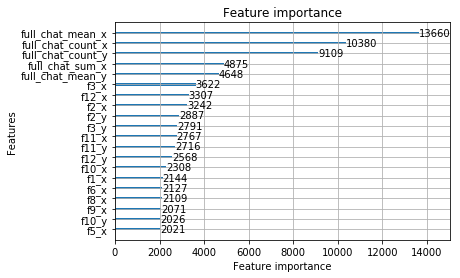

In [26]:
import matplotlib.pyplot as plt
lgb.plot_importance(lgb_load, max_num_features=20)
plt.show()

In [27]:
sub=pd.DataFrame()
sub['id']=ids
sub['is_chat']=test_preds
#sub.to_csv('lgb_fe_500.csv',index=False)
#!zip lgb_fe_500.zip lgb_fe_500.csv

In [21]:
avg_preds=pd.read_csv('full_lgb_preds_avg.csv')

In [30]:
two_stack=(sub['is_chat']+avg_preds['is_chat'])/2

In [23]:
sub.to_csv('lgb_fe_500_avg.csv',index=False)
!zip lgb_fe_500_avg.zip lgb_fe_500_avg.csv

  adding: lgb_fe_500_avg.csv (deflated 60%)


In [28]:
scale_preds=pd.read_csv('full_lgb_scale_preds.csv')

In [29]:
three_stack=(sub['is_chat']+avg_preds['is_chat']+scale_preds['is_chat'])/3

In [31]:
sub['is_chat']=three_stack
sub.to_csv('lgb_fe_792_avg_scale.csv',index=False)
!zip lgb_fe_792_avg_scale.zip lgb_fe_792_avg_scale.csv

  adding: lgb_fe_792_avg_scale.csv (deflated 60%)


In [32]:
sub['is_chat']=two_stack
sub.to_csv('lgb_fe_792_avg.csv',index=False)
!zip lgb_fe_792_avg.zip lgb_fe_792_avg.csv

  adding: lgb_fe_792_avg.csv (deflated 60%)


In [33]:
sub['is_chat']=(test_preds+scale_preds['is_chat'])/2
sub.to_csv('lgb_fe_792_scale.csv',index=False)
!zip lgb_fe_792_scale.zip lgb_fe_792_scale.csv

  adding: lgb_fe_792_scale.csv (deflated 60%)
